<h1>Streaming Platfoms Stats</h1>
<h3>
DC-DSE Assignment 2024/25
<br>
Federica Tamerisco
</h3>

<h2>P1</h2>
For this project I decided to work on Netflix and Prime Video's datasets.

I used the ones available on [Kaggle](https://www.kaggle.com/), published by [OctopusTeam](https://www.kaggle.com/octopusteam).
<br>
They both share the same attributes, correlated to a certain media content:

- Title
- Type (movie or tv show)
- Genres
- Release Year
- IMDB ID
- IMDB Average Rating
- IMDB Number of Votes
- Available Countries (in which this content can be viewed)

For example:

In [2]:
import pandas

csv = 'DATASET/netflix.csv'
df = pandas.read_csv(csv)
df.head(1)

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,518745.0,"AT, CH, DE"


I chose to run 5 queries:

- Top 20 highest rated titles on Netflix
- Top 10 most popular genres on Prime Video
- The number of titles released in 2001 on both platforms
- Most popular movie present on both platforms
- The tv show(s) that is (are) most distributed

For each I used the same initialization:

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import time as t

spark = SparkSession \
    .builder \
    .appName("Streaming Platforms Stats") \
    .getOrCreate()

<h2>P2</h2>
<h3>Query 1 - Top 20 highest rated titles on Netflix</h3>

In [ ]:
netflixPath = "hdfs:/user/user_dc_11/netflix.csv"

start = t.time()

netflix = spark.read.csv(netflixPath, header=True, inferSchema=True)
print("Top 20 highest rated titles on Netflix")

content = netflix.select("title", "imdbAverageRating")
top_titles = content.orderBy(col("imdbAverageRating").desc())
top_titles.show(20, truncate=False);

finish = t.time()

time = finish - start
print(f"Time spent: {time}")

spark.stop()

To compute this task I started from Netflix’ dataset.
<br>
First of all, I selected <tt>title</tt> and <tt>imdbAverageRating</tt>, to display the relevant contents and the rating.
<br>
Then I ordered by ratings in descending order.
<br>
Finally, I displayed only the top 20.

<h3>Query 2 - Top 10 most popular genres on Prime Video</h3>

In [ ]:
prime = spark.read.csv(primePath, header=True, inferSchema=True)
print("Top 10 most popular genres on Prime Video")

genres = prime.withColumn("genre", explode(split(col("genres"), ", ")))
count = genres.groupBy("genre").count()
top_genres = count.orderBy(col("count").desc())
top_genres.show(10, truncate=False)

I started from the Prime’s dataset.
<br>
To work on the <tt>genres</tt> column, I first had to split the strings by using the $,$ as a separator.
<br>
Then I grouped by the new created differentiation and counted the total.
<br>
Finally I ordered in descending order and showed the top 10.

<h3>Query 3 - The number of titles released in 2001 on both platforms</h3>

In [ ]:
netflix = spark.read.csv(netflixPath, header=True, inferSchema=True)
prime = spark.read.csv(primePath, header=True, inferSchema=True)
print("The number of titles released in 2001 on both platforms")

netflix_2001 = netflix.select("title", "releaseYear").filter(col("releaseYear") == 2001)
prime_2001 = prime.select("title", "releaseYear").filter(col("releaseYear") == 2001)
titles = netflix_2001.union(prime_2001).distinct()
count = titles.count()
print(f"The number of titles from 2001 is {count}")

I started from both datasets.
<br>
First of all I selected <tt>title</tt> and <tt>releaseYear</tt> and filtered by the year.
<br>
To compare the two datasets I had to unite them by the year $2001$, removing the duplicates.
<br>
In the end I counted the resulting titles.

<h3>Query 4 - Most popular movie present on both platforms</h3>

In [ ]:
netflix = spark.read.csv(netflixPath, header=True, inferSchema=True)
prime = spark.read.csv(primePath, header=True, inferSchema=True)
print("Most popular movie present on both platforms")

netflix_movies = netflix.filter(col("type") == "movie").select("title", "imdbAverageRating")
prime_movies = prime.filter(col("type") == "movie").select("title", "imdbAverageRating")
movies = netflix_movies.join(prime_movies, on="title", how="inner")
movies = movies.select("title", netflix_movies["imdbAverageRating"])
most_popular = movies.orderBy(col("imdbAverageRating").desc()).limit(1)
most_popular.show(truncate=False)

I started from both datasets.
<br>
I selected <tt>title</tt> and <tt>imdbAverageRating</tt> and then filtered by <tt>type</tt>, to consider only the movies.
<br>
To compare the datasets I proceeded with an inner join on <tt>title</tt>: this way I specifically looked for movies that are present on both datasets.
<br>
I then selected <tt>title</tt> and <tt>imdbAverageRating</tt> on the remaining tuples.
<br>
Finally, I ordered by <tt>imdbAverageRating</tt> and limited to only the first result.

<h3>Query 5 - The tv show(s) that is (are) most distributed</h3>

In [ ]:
netflix = spark.read.csv(netflixPath, header=True, inferSchema=True)
prime = spark.read.csv(primePath, header=True, inferSchema=True)
print("The tv show(s) that is (are) most distributed")

netflix_tv = netflix.filter(col("type") == "tv").select("title", "availableCountries")
prime_tv = prime.filter(col("type") == "tv").select("title", "availableCountries")
tv = netflix_tv.union(prime_tv).distinct()

country_array = tv.withColumn("availableCountriesArray", split(col("availableCountries"), ", "))
country_count = country_array.select("title", "availableCountries", size(col("availableCountriesArray")).alias("count"))
max_countries = country_count.select(max("count").alias("max")).collect()[0]["max"]
most_distributed = country_count.filter(col("count") == max_countries)

truncated = most_distributed.withColumn("availableCountries", substring(col("availableCountries"), 1, 100))
truncated.show(truncate=False)

I started from both datasets.
<br>
I selected <tt>title</tt> and <tt>availableCountries</tt> and filtered by <tt>type</tt> to consider only the tv shows.
<br>
To compare the datasets I united them and then created an array with all the countries.
<br>
Then I counted the available countries of each title.
<br>
Finally I selected the maximum count and filtered by it.

<h2>P3</h2>
To analyze the execution statistic, I run the tasks with different configurations:

- <tt>local[1]</tt>
- <tt>local[4]</tt>
- <tt>local[*]</tt>
- <tt>yarn</tt>

<div style="display: flex">
  <div>
    <h3>Q1</h3>
    <table>
      <tr>
        <th>Mode</th>
        <th>Execution Time (s)</th>
      </tr>
      <tr>
        <td>local[1]</td>
        <td>8.324000120162964</td>
      </tr>
      <tr>
        <td>local[4]</td>
        <td>8.210103273391724</td>
      </tr>
      <tr>
        <td>local[*]</td>
        <td>8.254265546798706</td>
      </tr>
      <tr>
        <td>yarn</td>
        <td>8.65674877166748</td>
      </tr>
    </table>
  </div>
  
  <div>
    <h3>Q2</h3>
    <table>
      <tr>
        <th>Mode</th>
        <th>Execution Time (s)</th>
      </tr>
      <tr>
        <td>local[1]</td>
        <td>12.35227370262146</td>
      </tr>
      <tr>
        <td>local[4]</td>
        <td>10.846345663070679</td>
      </tr>
      <tr>
        <td>local[*]</td>
        <td>10.839778661727905</td>
      </tr>
      <tr>
        <td>yarn</td>
        <td>10.931915760040283</td>
      </tr>
    </table>
  </div>
</div>

<br>

<div style="display: flex">
  <div>
    <h3>Q3</h3>
    <table>
      <tr>
        <th>Mode</th>
        <th>Execution Time (s)</th>
      </tr>
      <tr>
        <td>local[1]</td>
        <td>14.321255922317505</td>
      </tr>
      <tr>
        <td>local[4]</td>
        <td>11.917307615280151</td>
      </tr>
      <tr>
        <td>local[*]</td>
        <td>11.607523918151855</td>
      </tr>
      <tr>
        <td>yarn</td>
        <td>12.158512592315674</td>
      </tr>
    </table>
  </div>

  <div>
    <h3>Q4</h3>
    <table>
      <tr>
        <th>Mode</th>
        <th>Execution Time (s)</th>
      </tr>
      <tr>
        <td>local[1]</td>
        <td>11.16390347480774</td>
      </tr>
      <tr>
        <td>local[4]</td>
        <td>11.058234214782715</td>
      </tr>
      <tr>
        <td>local[*]</td>
        <td>10.735490798950195</td>
      </tr>
      <tr>
        <td>yarn</td>
        <td>12.107340812683105</td>
      </tr>
    </table>
  </div>
</div>

<h3>Q5</h3>
<table>
  <tr>
    <th>Mode</th>
    <th>Execution Time (s)</th>
  </tr>
  <tr>
    <td>local[1]</td>
    <td>17.674784898757935</td>
  </tr>
  <tr>
    <td>local[4]</td>
    <td>14.080812931060791</td>
  </tr>
  <tr>
    <td>local[*]</td>
    <td>13.790724515914917</td>
  </tr>
  <tr>
    <td>yarn</td>
    <td>13.573800325393677</td>
  </tr>
</table>

<h3>Summary</h3>
I calculated the average of the execution time with each mode:

Text(0, 0.5, 'Execution Time (s)')

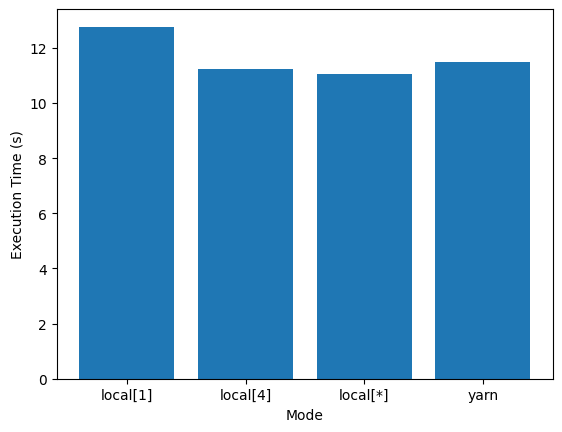

In [4]:
import matplotlib.pyplot as plt

modes = ['local[1]', 'local[4]', 'local[*]', 'yarn']

values = [
    12.7672436237335208,
    11.222560739517212,
    11.0455566883087156,
    11.4856636524200438
]

plt.bar(modes, values);
plt.xlabel('Mode')
plt.ylabel('Execution Time (s)')

As we can see, the use of a single thread results in more time to execute the task, as there is no parallelization.
<br>
With more threads the time decreases.
<br>
Using a cluster setup doesn't significantly reduce execution time compared to using all available threads locally: this happens because the overhead caused by distributing the task across multiple nodes is more significant than the benefits of parallel execution.